# Game of Life
Our week 6 workbook, available on Github from the powderflask/cap-comp215 repository.
As usual, the first code block just imports the modules we will use.

In [1]:
%matplotlib inline

import re
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

## 2D Elementary Cellular Automata
The state of our CA is now a 2D matrix, but we continue to restrict values in each cell to $0$ or $1$

In [2]:
ca_state = np.random.randint(2, size=(10, 10), dtype=np.uint8)
ca_state

array([[1, 0, 0, 1, 0, 0, 0, 1, 1, 0],
       [1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
       [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
       [1, 1, 0, 0, 1, 0, 0, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 1, 1, 1, 0, 0],
       [0, 1, 1, 0, 1, 1, 0, 1, 0, 1],
       [1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 0, 1, 0, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 1]], dtype=uint8)

And the "neighbourhood" of a cell is now a $3 x 3$ matrix sometimes called the [Moore Neighbourhood](https://en.wikipedia.org/wiki/Moore_neighborhood)

In [3]:
kernel = np.array(
    [
        [1, 1, 1],
        [1, 0, 1],
        [1, 1, 1]
    ]
)
kernel

array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 1]])

### Correlation (Sliding Dot-Product) in 2D
We encode the rules for Game of Life using a 2D [kernel](https://en.wikipedia.org/wiki/Kernel_(image_processing)) (which is just a 2D analog to the 1D "window" we used for 1D CAs).
The `kernel` defined above simply **counts** the number of "live" neighbours.  Can you see why?

In [4]:
neighbour_count = correlate2d(ca_state, kernel, mode='same')
neighbour_count

array([[1, 3, 3, 2, 3, 2, 4, 4, 4, 3],
       [2, 5, 4, 4, 5, 3, 5, 6, 6, 3],
       [4, 5, 4, 5, 4, 4, 6, 6, 7, 5],
       [4, 6, 6, 5, 4, 4, 4, 3, 4, 2],
       [5, 7, 5, 3, 4, 3, 5, 4, 4, 2],
       [4, 7, 6, 5, 5, 4, 5, 2, 3, 1],
       [5, 7, 6, 5, 4, 4, 6, 2, 4, 1],
       [4, 7, 7, 6, 6, 4, 4, 3, 5, 3],
       [4, 7, 8, 7, 6, 6, 4, 4, 4, 3],
       [3, 4, 5, 5, 4, 4, 3, 3, 4, 2]])

## Rules of Life
The rules are very simple:
  1. if a cell is alive, it remains alive if it has 2 or 3 live neighbours, otherwise it dies;
  2. if a dead cell, has **exactly** 3 neighbours it becomes alive.

In [5]:
next_state = (neighbour_count == 3) | (neighbour_count == 2) & ca_state
next_state

array([[0, 1, 1, 1, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 1, 0, 1]], dtype=uint8)

`numpy.array` is doing a lot of work for us above by performing both $matrix \times scalar$ operations (e.g., check each cell for equality and produce a 2D matrix of `bool`) and $matrix \times matrix$ operations (e.g., apply `or` and `and` operations to pairs of boolean matricies).

### 2D Correlation with a 2D Kernel and 19 state lookup table (0 - 18)
Notice the number of neighbours above can range from $0$ to $8$, so if we use a kernel that counts the centre cell as $10$, we get unique state values ranging from $0$ to $18$
In this case, the centre cell will be alive in the next generation *iff* the correlation result is $3$ (rule 2) or $12$ or $13$ (rule 1)
Just like in the 1D case, we can make the calculation more efficient by "pre-computing" each possible transition in a lookup table.
Thus, we get...

In [6]:
life_kernel = np.array(
    [
        [1, 1, 1],
        [1, 10, 1],
        [1, 1, 1]
    ]
)

# indexes represent "number of neighbours + 10x centre cell"
life_transitions = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

# use correlate (sliding dot product) to compute the indexes, then lookup next state in lookup vector.
indexes = correlate2d(ca_state, life_kernel, mode='same')
new_state = life_transitions[indexes]
print(ca_state)
print(indexes)
print(new_state)

[[1 0 0 1 0 0 0 1 1 0]
 [1 0 1 1 0 1 1 1 1 1]
 [0 1 1 0 1 1 0 1 1 0]
 [1 1 0 0 1 0 0 1 1 1]
 [1 1 1 1 0 1 0 0 0 0]
 [1 1 1 0 0 1 1 1 0 0]
 [0 1 1 0 1 1 0 1 0 1]
 [1 1 1 1 0 1 0 0 0 1]
 [1 1 1 1 1 0 1 0 1 1]
 [0 1 1 1 1 1 1 1 0 1]]
[[11  3  3 12  3  2  4 14 14  3]
 [12  5 14 14  5 13 15 16 16 13]
 [ 4 15 14  5 14 14  6 16 17  5]
 [14 16  6  5 14  4  4 13 14 12]
 [15 17 15 13  4 13  5  4  4  2]
 [14 17 16  5  5 14 15 12  3  1]
 [ 5 17 16  5 14 14  6 12  4 11]
 [14 17 17 16  6 14  4  3  5 13]
 [14 17 18 17 16  6 14  4 14 13]
 [ 3 14 15 15 14 14 13 13  4 12]]
[[0 1 1 1 1 0 0 0 0 1]
 [1 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1]
 [0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 1 0 1]]


## Display CA as 2-D image

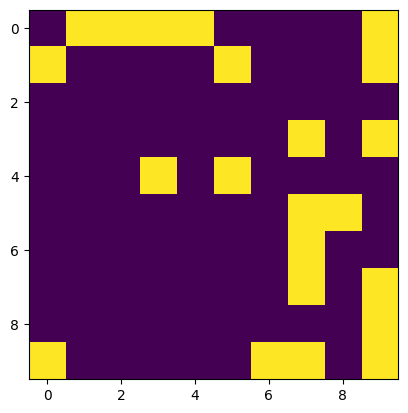

In [7]:
plt.imshow(new_state)

as usual, let's tidy that up a bit and wrap it in an abstraction for re-use...

In [8]:
def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()   # allow caller to supply matplotlib axes, or draw on pyplot's current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    axes.imshow(array, cmap='Blues', interpolation='none')

## A simple Game of Life class
As usual, let's package up what we've developed so far into a small re-usable class.

In [9]:
class Life2D:
    """ An basic 2D Cellular Automata that implementes Conway's Game of Life """
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])

    rules = np.zeros(19, dtype=np.uint8)
    rules[[3, 12, 13]] = 1

    def __init__(self, n_rows, n_cols=None):
        """ Construct a n_rows x n_cols 2D CA """
        n_cols = n_cols or n_rows  # i.e., n_cols if n_cols is not None and n_cols != 0 else n_rows
        self.state = np.random.randint(2, size=(n_rows, n_cols), dtype=np.uint8)

    def step(self):
        """Executes one time step. """
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        self.state = self.rules[transitions]

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()
        plot_2D_array(self.state, axes, f"Conway's Game of Life {step}")

and a small test to show how `Life2D` works...

<ipython-input-10-a21c97e577b9>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, n_steps, step)


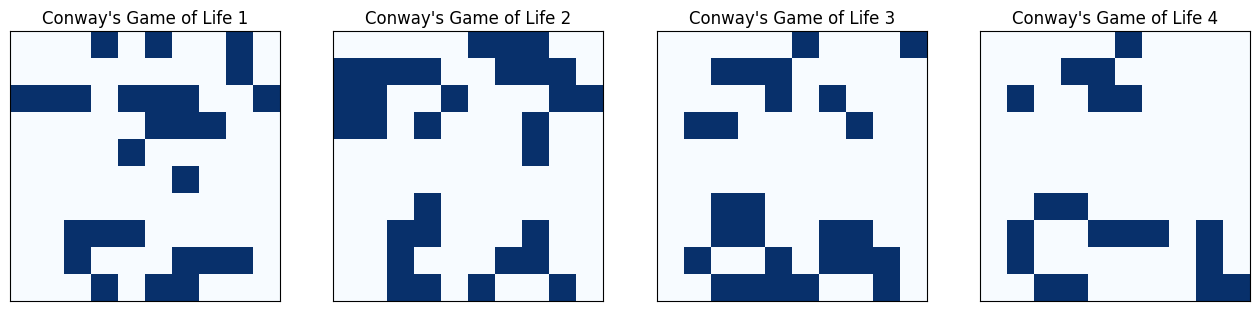

In [10]:
l = Life2D(10)
n_steps = 4
fig, ax = plt.subplots(figsize=(n_steps * 4, 4))
for step in range(1, n_steps + 1):
    plt.subplot(1, n_steps, step)
    l.step()
    l.draw(step=step)

### Visualizing a 2D simulation model
For 1D CAs, we could use a 2D image to visualize the CA progression over time.
For 2D CAs, we could try using time as a 3rd axis to generate a 3D visualziation, but really need VR to explore a 3D visualization.
Instead, we'll use a simple 2D ["stop motion" animation](https://en.wikipedia.org/wiki/Animation).
Luckily, `matplotlib` makes animating a 2D plot fairly straight-forward.

Here is a generic class that animates any 2D model that provides step() and draw() methods, and uses matplotlib to render its state.
It provides methods to `animate()` the model directly in the output display or `show()` the animation in an interactive viewer.

See [Matplotlib animation in Jupyter](https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/) by our textbook author for a discussion of the pros and cons of various animation techniques in jupyter notebooks.

In [11]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
        except KeyboardInterrupt:
            pass
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

In [12]:
# Create the animation
life = Life2D(30)
Animation2D(life, frames=20).show()

## For Project Idea: Life Patterns
This code demonstrates how to use a "regular expression" (re) to parse run-length encoded data
 - a regular expression to parse the GoL RLE pattern

In [13]:
rle_pairs = r'(\d+)?([bo$!])'  # 2-tuples, (n, c), where n is optional positive integer and C is one of b,o,$,!
# pattern from https://conwaylife.com/patterns/gosperglidergun.rle
data = '''
24bo11b$22bobo11b$12b2o6b2o12b2o$11bo3bo4b2o12b2o$2o8bo5bo3b2o14b$2o8bo3bob2o4bobo11b$10bo5bo7bo11b$11bo3bo20b$12b2o!
'''
matches = re.findall(rle_pairs, data)
print(matches)

[('24', 'b'), ('', 'o'), ('11', 'b'), ('', '$'), ('22', 'b'), ('', 'o'), ('', 'b'), ('', 'o'), ('11', 'b'), ('', '$'), ('12', 'b'), ('2', 'o'), ('6', 'b'), ('2', 'o'), ('12', 'b'), ('2', 'o'), ('', '$'), ('11', 'b'), ('', 'o'), ('3', 'b'), ('', 'o'), ('4', 'b'), ('2', 'o'), ('12', 'b'), ('2', 'o'), ('', '$'), ('2', 'o'), ('8', 'b'), ('', 'o'), ('5', 'b'), ('', 'o'), ('3', 'b'), ('2', 'o'), ('14', 'b'), ('', '$'), ('2', 'o'), ('8', 'b'), ('', 'o'), ('3', 'b'), ('', 'o'), ('', 'b'), ('2', 'o'), ('4', 'b'), ('', 'o'), ('', 'b'), ('', 'o'), ('11', 'b'), ('', '$'), ('10', 'b'), ('', 'o'), ('5', 'b'), ('', 'o'), ('7', 'b'), ('', 'o'), ('11', 'b'), ('', '$'), ('11', 'b'), ('', 'o'), ('3', 'b'), ('', 'o'), ('20', 'b'), ('', '$'), ('12', 'b'), ('2', 'o'), ('', '!')]
